In [2]:
import sys, os

#Our project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), os.pardir))
sys.path.append(PROJECT_ROOT)

#Local packages loaded from src specifying useful constants, and our custom loader
from util.constants import DATA_PATHS
from util.dataset import OcelotDatasetLoader, PixelThreshold
from util.unet import Unet
from util.evaluate import evaluate

#other modules of interest
import torch
from torch.utils.data import DataLoader
import torchmetrics
from torchvision import transforms as transf
from PIL import Image
import numpy as np
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from monai.losses import DiceCELoss, DiceLoss, MaskedDiceLoss

In [3]:
my_device = torch.device(device = 'cuda' if torch.cuda.is_available() else 'cpu')
pin_memory = True if my_device == 'cuda' else False
d_type_f32 = torch.float32
batch_size = 1
learning_rate= 1e-3
weight_decay = 1e-3
nepochs = 10
val_percent=0.1
train_percent = 1 - val_percent
image_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor()])
mask_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor(), PixelThreshold(lower_thresh=1, upper_thresh=255)])

#First we need to specify some info on our model: we have 3 channels RGB, 1 class: tissue
model = Unet(n_channels=3, n_classes=1)

print(my_device)

cuda


In [4]:
#Load our data in our special dataloader
TissTrainData = OcelotDatasetLoader(paths = DATA_PATHS,
                                    dataToLoad = 'Tissue',
                                    image_transforms=image_transforms,
                                    mask_transforms=mask_transforms)

#Establish a train/validation split size
TrainValSplit = [int(0.8*len(TissTrainData)), len(TissTrainData) - int(0.8*len(TissTrainData))]

#Establish our training and validation data using torch's built in random_split on our own formatted data
TrainingData, ValidationData = torch.utils.data.random_split(TissTrainData, [train_percent, val_percent])

In [5]:
#Load into Pytorch's built in DataLoader
TissTrainLoader = DataLoader(TissTrainData, batch_size=batch_size, num_workers=4)

TissValLoader = DataLoader(ValidationData, batch_size=batch_size, num_workers=4)

In [6]:
def tiss_training_loop(
    model,
    device,
    epochs,
    batch_size:         int = 128,
    learning_rate:      float = 0.0001,
    val_percent:        float = 0.2,
    amp:                bool = False,
    weight_decay:       float = 1e-3,
    momentum:           float = 0.98,
    gradient_clipping:  float = 1.0,
    image_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor()]),
    mask_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor(), PixelThreshold(lower_thresh=1, upper_thresh=255)]),
):
    #Loading our data, performing necessary splits (update with test set in future), and send to loader
    print("Loading Ocelot dataset...")

    training_data = OcelotDatasetLoader(paths=DATA_PATHS,
                                        dataToLoad='Tissue',
                                        image_transforms=image_transforms,
                                        mask_transforms=mask_transforms)
    train_percent = 1 - val_percent
    train_N, val_N = [int(train_percent*len(training_data)), 
                      int(val_percent*len(training_data))]
    train_split, val_split = torch.utils.data.random_split(training_data, 
                                                           [train_percent, val_percent])
    train_loader = DataLoader(train_split, 
                              batch_size=batch_size, 
                              num_workers=4)
    val_loader = DataLoader(val_split, 
                            batch_size=batch_size, 
                            num_workers=4)

    print(f"Found {len(training_data)} data samples.")   
        
    #Initialize optimizer, loss, learning rate, and loss scaling
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=momentum,
                                weight_decay=weight_decay)
    #criterion = torch.nn.BCEWithLogitsLoss() if model.n_classes == 1 else None #TODO: IMPLEMENT BEHAVIOR FOR NON BINARY SEGMENTATION (ensure model.n_classes=1 for now)
    criterion = DiceCELoss(sigmoid=True)

    #we use max here as our purpose is to maximize our measured metric (DICE score of 1 is better: more mask similarity)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
    
    #Only for AMP. prevents loss of values due to switch between multiple formats
    grad_scaler = torch.cuda.amp.grad_scaler.GradScaler(enabled=amp)
    #global_step = 0
    #epoch_loss = 0
    model.to(device)
    val_loss_metric = []
    train_loss_metric = []

    #Begin training
    for epoch in range(epochs):
        model.train()
        
        with tqdm(total=train_N, desc=f'Epoch {epoch+1}/{epochs}') as progress_bar:
            
            for batch in train_loader:
                images, true_masks = batch[0], batch[1]
                assert images.shape[1] == model.n_channels, f"Expected {model.n_channels} channels from image but received {images.shape[1]} channels instead."
                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last if amp==True else torch.preserve_format)
                true_masks = true_masks.to(device=device, dtype=torch.float32)

                with torch.autocast(device.type if device.type == 'cuda' else 'cpu', enabled=amp):
                    infer_masks = model(images)
                    
                    if model.n_classes == 1:
                        loss = criterion(infer_masks, true_masks.float())
                        train_loss = loss
                        train_loss_metric.append(train_loss.detach().cpu())
                        #loss += 0.5 * dice_score #TODO: loss += dice score?
                    
                    else:
                        #TODO: EVALUATE CRITERION FOR MULTICLASS SEGMENTATION
                        loss = ...
                        return NotImplementedError

                optimizer.zero_grad()

                #Scales w/ AMP enabled from loss and does backprop
                grad_scaler.scale(loss).backward()

                #Grad clipping restricts gradient to a range. Research vanishing gradient for more.
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                
                #Step the optimizer for new model parameters (keeping grad scaling in mind assuming AMP)
                grad_scaler.step(optimizer)
                grad_scaler.update()
                progress_bar.update(images.shape[0])

                #global_step += 1
                #Add to our epoch loss from our element in loss tensor
                #epoch_loss += loss.item() #TODO: TRAIN LOSS

            #Move on to evaluation
            val_metric = evaluate(model, val_loader, device, amp=False) #TODO: UPDATE EVALUATION METHOD FOR MULTICLASS
            scheduler.step(val_metric)

            val_loss_metric.append(val_metric)

            #TODO: Deepcopy and save the model with WORST/best? val accuracy

    return train_loss_metric, val_loss_metric

train_score, val_score = tiss_training_loop(model=model,
                           device=my_device,
                           epochs=50,
                           batch_size=32,
                           amp=False,
                           val_percent=0.2,
                           mask_transforms=mask_transforms,
                           image_transforms=image_transforms)


Loading Ocelot dataset...
Found 400 data samples.


Epoch 1/50: 100%|██████████| 320/320 [00:30<00:00, 67.93it/s]c:\Users\liemj\anaconda3\envs\REU2023\Lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 50/50: 100%|██████████| 320/320 [00:28<00:00, 11.23it/s]


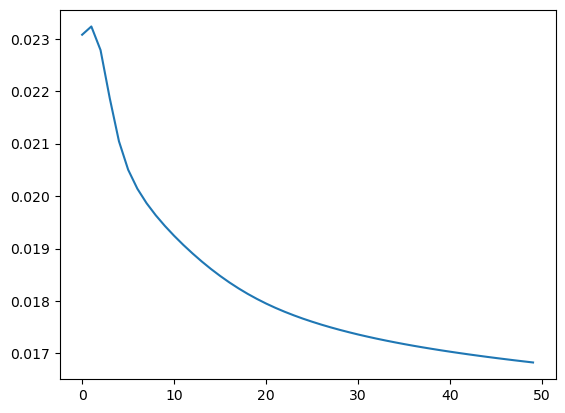

In [11]:
#plt.plot(train_score)
plt.plot(val_score)

In [30]:
image_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor()])
mask_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor(), PixelThreshold(lower_thresh=1, upper_thresh=255)])

#Load our data in our special dataloader
TissTrainData = OcelotDatasetLoader(paths = DATA_PATHS, dataToLoad = 'Tissue', mask_transforms=mask_transforms, image_transforms=image_transforms)

#Load into Pytorch's built in DataLoader
TissTrainLoader = DataLoader(TissTrainData, batch_size=batch_size, num_workers=4)

y_true = TissTrainLoader.dataset[8][1]
y_image = TissTrainLoader.dataset[8][0]
y_pred = model(y_image.unsqueeze(0))

print(y_true)

#print(dice_coef(y_pred, y_pred))

y_out = y_true.squeeze().cpu().numpy()
predicted_mask = Image.fromarray((y_out * 255).astype(np.uint8))
#predicted_mask

#dice_coef(y_pred, y_true)
plt.imshow(predicted_mask)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [8]:
evaluate(model, TissTrainLoader, device=my_device, amp=False)

0.6096161109209061